# Energy Surface

> Plot potential energy surfaces and calculate freqencies for symmetric triatomics 

In [ ]:
#| default_exp optimisation

In [ ]:
#| export
#| echo: false
import os
import re
import linecache
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

In [ ]:
#| echo: false
h2opath = ('../Ex2/H2Ooutfiles')
h2spath = ('../Ex2/H2Soutfiles')

In [ ]:
#| hide
basepath = os.getcwd()
print(os.getcwd())
os.chdir(h2opath) 
print(os.getcwd())
os.chdir(basepath )

c:\Users\kirpa\OneDrive\Documents\ChemIITools\nbs
c:\Users\kirpa\OneDrive\Documents\ChemIITools\Ex2\H2Ooutfiles


In [ ]:
#| export
def parse_out(file):
    """
    parses an out file of a symmetric triatomic for the bond length, angle and SCF energy 
    """
    shape_lookup = "Symbolic Z-matrix"
    energy_lookup = "SCF Done"
    e_search = r'(?<=SCF Done:  E\(RHF\) =).+?(?=A\.U\.)'
    r_search = r'(?<=1).+?(?= 2 )'
    a_search = r'(?<= 2 ).*'
    shape_line = None
    with open(file) as myFile:
        for num, line in enumerate(myFile):
                if shape_lookup in line:
                        shape_line = num+4
                if num == shape_line:
                        r= float(re.findall(r_search,line)[0])
                        angle= float(re.findall(a_search,line)[0])
                if energy_lookup in line:
                         energy= float(re.findall(e_search,line)[0])




    return ((r, angle), energy)

    

In [ ]:
h2o_vals = {}
for filename in os.listdir(h2opath):
    output = parse_out(os.path.join(h2opath, filename))
    h2o_vals[output[0]] = output[1]

In [ ]:
#| echo: false
h2s_vals = {}
for filename in os.listdir(h2spath):
    output = parse_out(os.path.join(h2spath, filename))
    h2s_vals[output[0]] = output[1]

In [ ]:
#| export
def _func(r,theta, dict):
    # dictionary lookup
    return dict[(r,theta)]
def _dict_to_mesh(dict):
    """
    convert a dictioonary of ((r,theta) z) values to a mesh
    """
    r,theta = zip(*dict.keys())
    r = np.unique(r)
    theta = np.unique(theta)
    r,theta= np.meshgrid(r,theta)
    z = np.array([_func(r,theta, dict) for (r,theta) in zip(r.ravel(), theta.ravel())]).reshape(r.shape)




    return r,theta, z

In [ ]:
#| export
def surface_plot(dict, fname = None):
    """Plots a surface from the output of the regex"""
    r,theta, z = _dict_to_mesh(dict)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(r,theta, z, cmap=cm.viridis_r, linewidth=0)
    plt.xlabel('Bond Length/ $\AA$')
    plt.ylabel('Bond Angle/ $^\circ$')
    ax.set_zlabel('Energy/ $E_{h}$')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname)
    plt.show()

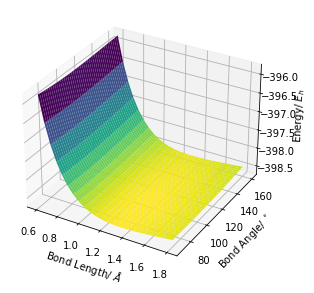

In [ ]:
surface_plot(h2s_vals)

In [ ]:
#| export
def heatmap(dict, fname = None):
    """Plots a heatmap from the output of the regex"""
    r,theta, z = _dict_to_mesh(dict)
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()

    c = ax.pcolormesh(r,theta, z, cmap=cm.viridis_r, vmin=z_min, vmax=z_max)
    # set the limits of the plot to the limits of the data
    ax.axis([r.min(), r.max(), theta.min(), theta.max()])
    fig.colorbar(c, ax=ax)
    plt.xlabel('Bond Length/ $\AA$')
    plt.ylabel('Bond Angle/ $^\circ$')
    if fname is not None:
        plt.savefig(fname)
    plt.show()

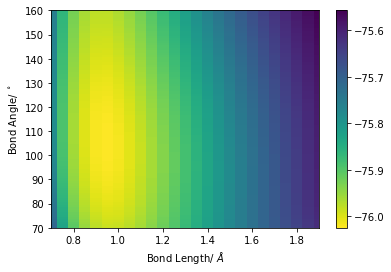

In [ ]:
heatmap(h2o_vals)

In [ ]:
#| export
def vib_calc(dict, mass = 1.6735575E-27):
    """
    Calculate optimum bond length and angle and symmetric stretch and bending frequencies.
    
    Default mass is that of the hydrogen atom
    """
    h_to_J = 4.3597482E-18 # hartree to joule conversion factor
    deg_to_r = np.pi/180 # degrees to radians
    A_to_m = 1E-10 # angstrom to m
    r_opt, theta_opt = min(dict, key=dict.get)
    r,theta = zip(*dict.keys())
    r = np.unique(r)
    theta = np.unique(theta)
    zr = [] # with constant theta
    ztheta = [] # with constant r

    for R in r:
        zr.append(dict[(R, theta_opt)]*h_to_J)

    zr = np.array(zr)
    r_adj = (r - r_opt)*A_to_m
    rslice = (r_adj>=.25*r_adj.min()) & (r_adj<=.25*r_adj.max())
    rfit = np.linspace(r_adj.min(), r_adj.max(), 1000)
    rquad = np.linspace(.4*r_adj.min(), .4*r_adj.max(), 1000)

    poly = np.polyfit(r_adj , zr, 8)
    quad = np.polyfit(r_adj [rslice], zr[rslice], 2)
    zfit = np.polyval(poly, rfit)
    zquad = np.polyval(quad, rquad)

    plt.plot(r_adj, zr,"ro")
    plt.plot(rfit, zfit)
    plt.plot(rquad, zquad)
    plt.xlabel('Bond Length from Optimum/ m')
    plt.ylabel('Energy/ J')
    plt.show()

    kr = 2*quad[0]
    mu_1 = 2*mass
    nu_r = np.sqrt(kr/mu_1)/(2*np.pi)

    for Theta in theta:
        ztheta.append(dict[(r_opt, Theta)]*h_to_J)

    ztheta = np.array(ztheta)
    theta_adj = (theta-theta_opt)*deg_to_r
    thetaslice = (theta_adj>=.25*theta_adj.min()) & (theta_adj<=.25*theta_adj.max())

    thetafit = np.linspace(theta_adj.min(), theta_adj.max(), 1000)
    thetaquad = np.linspace(.4*theta_adj.min(), .4*theta_adj.max(), 1000)
    poly = np.polyfit(theta_adj , ztheta, 8)
    quad = np.polyfit(theta_adj[thetaslice], ztheta[thetaslice], 2)
    zfit = np.polyval(poly, thetafit)
    zquad = np.polyval(quad, thetaquad)

  
    plt.plot(theta_adj, ztheta,"ro", markersize=2)
    plt.plot(thetafit, zfit)
    plt.plot(thetaquad, zquad)
    plt.xlabel('Bond Angle from Optimum/ rad')
    plt.ylabel('Energy/ J')
    plt.show()

    ktheta = 2*quad[0]
    mu_2 = 0.5*mass
    nu_theta = np.sqrt(ktheta/(mu_2*r_opt**2))/(2*np.pi)
    return r_opt, theta_opt, nu_r, nu_theta

Assuming around the equilibrium point, the relevant part of each polynomial is the quadratic, for the stretching frequency: $$E=E_{0}+\frac{1}{2}k_{r}(r-\bar{r})^{2}+\frac{1}{2}k_{\theta}(\theta-\bar{\theta})^{2}$$ and thus $$F = -\nabla E=\begin{pmatrix}-k_{r}r\\-k_{\theta}\theta \end{pmatrix}$$ and so $\nu_{r} = \frac{1}{2\pi}\sqrt{\frac{k_{r}}{\mu_{1}}}$ and $\nu_{\theta} = \frac{1}{2\pi}\sqrt{\frac{k_{\theta}}{r^{2}\mu_{2}}}$, where $\mu_{1}\approx 2 m_{u}$ and $\mu_{2}\approx 0.5 m_{u}$. For both water and hydrogen disulfide $m_{u}$ is the mass of the hydrogen atom

In [ ]:
#| hide
# output = parse_out("C:\\Users\\kirpa\\OneDrive\\Documents\\ChemIITools\\Ex2\\H2Ooutfiles\\H2O.r1.00theta94.0.out")
# output

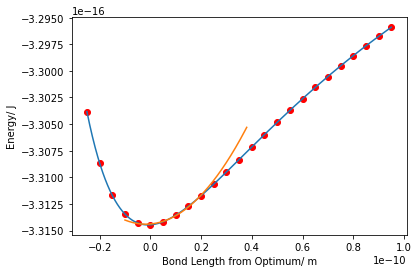

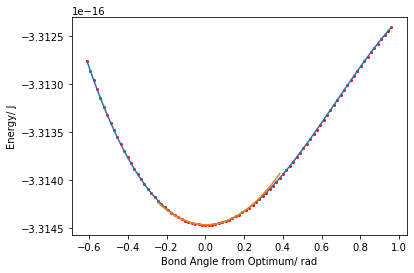

In [ ]:
r_opt, theta_opt, nu_r, nu_theta = vib_calc(h2o_vals)

In [ ]:
print('the optimum bond length of water is ', r_opt, ' angstroms with angle ', theta_opt, ' degrees' )
print('the stretching frequency ', nu_r, ' Hz and bending frequency ', nu_theta, ' Hz' )

the optimum bond length of water is  0.95  angstroms with angle  105.0  degrees
the stretching frequency  93321760256725.52  Hz and bendong frequency  4992.563486679283  Hz


Similarly for hydrogen sulfide

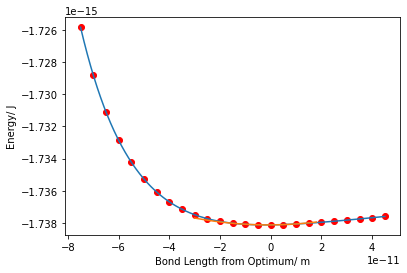

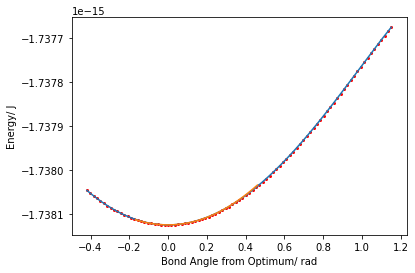

the optimum bond length of H2S is  1.35  angstroms with angle  94.0  degrees
the stretching frequency  87598136384533.97  Hz and bendong frequency  3761.829657979881  Hz


In [ ]:
r_opt, theta_opt, nu_r, nu_theta = vib_calc(h2s_vals)
print('the optimum bond length of H2S is ', r_opt, ' angstroms with angle ', theta_opt, ' degrees' )
print('the stretching frequency ', nu_r, ' Hz and bending frequency ', nu_theta, ' Hz' )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()